In [32]:
import json

input_path = "teacher_dataset4.jsonl"

with open(input_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f, 1):
        try:
            json.loads(line)
        except json.JSONDecodeError as e:
            print(f"❌ 第 {i} 行格式错误：{e}")
            print(f"内容片段：{line[:200]}...\n")
            break


FileNotFoundError: [Errno 2] No such file or directory: 'teacher_dataset4.jsonl'

In [23]:
import json

input_path = "teacher_dataset4.jsonl"
output_path = "teacher_dataset4.json"

with open(input_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)


样本总数: 1199
平均长度: 1598.54
最短样本长度: 787
最长样本长度: 3217
90% 样本长度分位: 2098
95% 样本长度分位: 2327


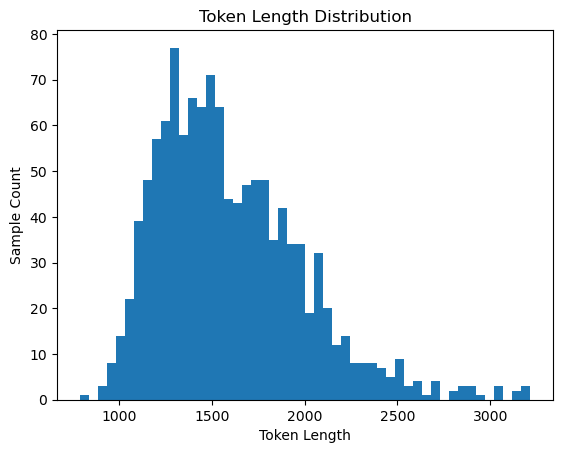

In [ ]:
import json
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt

dataset_path = "teacher_dataset.json"  # 替换为你的文件路径
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct", trust_remote_code=True)

token_lengths = []

# 读取整个文件
with open(dataset_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 文件是单个对象或列表
samples = data if isinstance(data, list) else [data]

for sample in samples:
    question = sample.get("question", "")
    docs = [doc.get("content", "") for doc in sample.get("documents", [])]
    teacher_answer = sample.get("teacher_answer", "")
    
    full_text = " ".join([question] + docs + [teacher_answer])
    
    # 用 tokenizer 统计 token 数
    tokens = tokenizer(full_text, truncation=False)["input_ids"]
    token_lengths.append(len(tokens))

# 统计长度分布
counter = Counter(token_lengths)
most_common_lengths = counter.most_common(20)

# --- 分析 ---
print(f"样本总数: {len(token_lengths)}")
print(f"平均长度: {sum(token_lengths)/len(token_lengths):.2f}")
print(f"最短样本长度: {min(token_lengths)}")
print(f"最长样本长度: {max(token_lengths)}")

# 90% / 95% 分位长度
import numpy as np
p90 = int(np.percentile(token_lengths, 90))
p95 = int(np.percentile(token_lengths, 95))
print(f"90% 样本长度分位: {p90}")
print(f"95% 样本长度分位: {p95}")

# --- 可视化 ---
plt.hist(token_lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Sample Count")
plt.show()


样本总数: 1199
平均长度: 636.36
最短样本长度: 386
最长样本长度: 1114
90% 样本长度分位: 768
95% 样本长度分位: 820


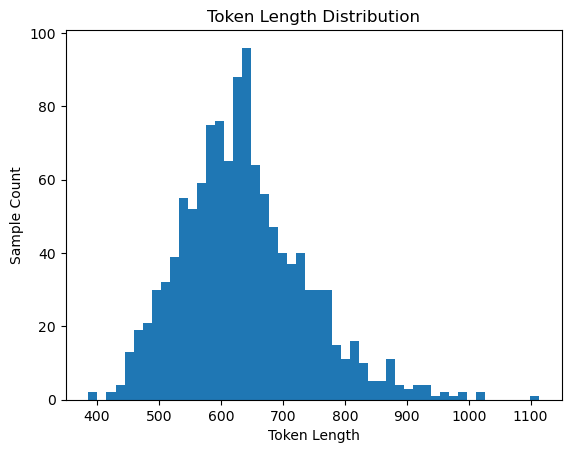

In [51]:
import json
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt

# --- 配置 ---
dataset_path = "teacher_dataset.json"  # 或者 .jsonl
text_field = "teacher_answer"  # 数据集中包含文本的字段
model_name = "Qwen/Qwen2.5-7B-Instruct"  # 和你的模型一致
cache_dir = None

# --- 初始化分词器 ---
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir, trust_remote_code=True)

# --- 读取数据 ---
token_lengths = []

with open(dataset_path, "r", encoding="utf-8") as f:
    # 如果是 jsonl，每行是一个 json 对象
    try:
        for line in f:
            item = json.loads(line)
            text = item.get(text_field, "")
            token_ids = tokenizer(text, add_special_tokens=True)["input_ids"]
            token_lengths.append(len(token_ids))
    except json.JSONDecodeError:
        # 如果是普通 json 列表
        f.seek(0)
        data = json.load(f)
        for item in data:
            text = item.get(text_field, "")
            token_ids = tokenizer(text, add_special_tokens=True)["input_ids"]
            token_lengths.append(len(token_ids))

# --- 分析 ---
print(f"样本总数: {len(token_lengths)}")
print(f"平均长度: {sum(token_lengths)/len(token_lengths):.2f}")
print(f"最短样本长度: {min(token_lengths)}")
print(f"最长样本长度: {max(token_lengths)}")

# 90% / 95% 分位长度
import numpy as np
p90 = int(np.percentile(token_lengths, 90))
p95 = int(np.percentile(token_lengths, 95))
print(f"90% 样本长度分位: {p90}")
print(f"95% 样本长度分位: {p95}")

# --- 可视化 ---
plt.hist(token_lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Sample Count")
plt.show()


In [ ]:
import json
import re

input_path = "teacher_dataset4.json"   # 输入文件
output_path = "teacher_dataset1.json"  # 输出文件


def extract_referenced_indices(answer_text):
    """提取 teacher_answer 中 [Doc1], [Doc3] 这类引用编号"""
    return [int(x) for x in re.findall(r"\[Doc(\d+)\]", answer_text)]


def update_references(answer_text, index_mapping):
    """根据 index_mapping 更新引用编号"""
    def repl(m):
        old_idx = int(m.group(1))
        new_idx = index_mapping.get(old_idx)
        return f"[文档{new_idx}]" if new_idx else ""  # 如果被删就去掉
    return re.sub(r"\[Doc(\d+)\]", repl, answer_text)


with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

processed_data = []

for idx, sample in enumerate(data, 1):
    docs = sample.get("documents", [])
    teacher_answer = sample.get("teacher_answer", "")

    # 提取被引用的编号
    referenced_indices = extract_referenced_indices(teacher_answer)

    # 找出所有 oracle 文档（索引、长度）
    oracle_info = [
        (i, len(d.get("content", "")))
        for i, d in enumerate(docs)
        if d.get("type") == "oracle"
    ]

    # 过滤掉被引用的 oracle
    removable_oracles = [(i, l) for i, l in oracle_info if i + 1 not in referenced_indices]

    # 删除两个 content 最长的 oracle
    to_remove = set(i for i, _ in sorted(removable_oracles, key=lambda x: x[1], reverse=True)[:2])

    # 重新构建 documents
    new_docs = [d for i, d in enumerate(docs) if i not in to_remove]

    # 构建旧编号 -> 新编号映射
    index_mapping = {}
    for new_idx, (old_idx, _) in enumerate([(i, d) for i, d in enumerate(docs) if i not in to_remove], start=1):
        index_mapping[old_idx + 1] = new_idx

    # 更新 teacher_answer 中的引用编号
    new_answer = update_references(teacher_answer, index_mapping)

    # 更新 sample
    sample["documents"] = new_docs
    sample["teacher_answer"] = new_answer
    processed_data.append(sample)

    if idx % 100 == 0:
        print(f"✅ 已处理 {idx} 条样本")

# 保存输出
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

print(f"\n✅ 全部完成，共 {len(processed_data)} 条样本")
print(f"结果已保存到: {output_path}")


✅ 已处理 100 条样本
✅ 已处理 200 条样本
✅ 已处理 300 条样本
✅ 已处理 400 条样本
✅ 已处理 500 条样本
✅ 已处理 600 条样本
✅ 已处理 700 条样本
✅ 已处理 800 条样本
✅ 已处理 900 条样本
✅ 已处理 1000 条样本
✅ 已处理 1100 条样本

✅ 全部完成，共 1199 条样本
结果已保存到: teacher_dataset.json


In [49]:
import json
import re

input_path = "teacher_dataset1.json"   # 输入文件

with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

print(data[0]['teacher_answer'])

- 问题: 如何制定2型糖尿病患者的长期随访计划？
- 假设/已知信息: 患者已被诊断为2型糖尿病，需制定长期管理与随访策略以预防急慢性并发症、维持血糖及其他代谢指标在目标范围内。
- CoT推理:
  1) 症状分析: 2型糖尿病本身常无明显急性症状，但若控制不佳可逐渐出现多饮、多尿、体重下降、疲劳等高血糖表现；更重要的是其慢性并发症风险（如视网膜病变、肾病、神经病变、心血管疾病）和急性并发症风险（如严重高血糖或低血糖）。因此，随访重点在于监测血糖控制水平及靶器官损害迹象。
  2) 鉴别诊断: 此处不涉及新发疾病鉴别，而是针对已有2型糖尿病的病情进展评估。需排除其他类型糖尿病（如LADA、MODY），但假设已确诊为典型2型糖尿病。
  3) 推荐检查: 
     - 血糖相关：HbA1c（每3–6个月一次，目标<7%）；
     - 肾脏功能：每年至少两次检测尿白蛋白排泄率（筛查糖尿病肾病）；
     - 眼科检查：每年进行眼底检查（筛查糖尿病视网膜病变）；
     - 心血管风险评估：血压监测（目标<130/85 mmHg）、血脂谱（LDL-C目标<100 mg/dL）、心电图或心脏风险评分；
     - 足部检查：定期评估感觉、脉搏、皮肤完整性（预防糖尿病足）；
     - 药物副作用监测：如使用SGLT2抑制剂注意泌尿生殖道感染，GLP-1受体激动剂注意胃肠道反应等。
- 初步诊断建议（含不确定度）: 对于已确诊的2型糖尿病患者，应建立结构化长期随访计划，核心包括血糖、血压、血脂达标管理，定期筛查微血管与大血管并发症，并根据个体风险调整治疗方案。该建议基于当前指南，不确定性较低（证据等级高）。
- 证据引用: [文档1] “为了减少大多数微血管并发症, 目标hba1c应小于7%。血压目标应为小于130/85 mmhg。应按照指南规定进行眼底检查, 每年至少两次检查尿白蛋白排泄。ldl胆固醇的目标应小于100 mg/dl。” + Source: StatPearls - Type 2 Diabetes (https://www.ncbi.nlm.nih.gov/books/NBK513253/)
- 不足信息与后续建议: 我不知道患者的具体年龄、病程、是否合并心血管疾病、肾功能状态、当前用药方案、HbA1c水平、是否有低血糖史等关键个体化信息。这

In [48]:
import json
import re

input_path = "teacher_dataset.json"   # 输入文件
output_path = "teacher_dataset1.json"  # 输出文件

def remove_emergency_section(answer_text):
    """
    删除 teacher_answer 中的‘紧急就医指示（红旗症状）’段落
    """
    # 使用正则匹配该部分（从标题开始到句号结尾）
    pattern = r"- 紧急就医指示（红旗症状）:[\s\S]*?(?=(\n- |$))"
    cleaned_text = re.sub(pattern, "", answer_text).strip()
    return cleaned_text


with open(input_path, "r", encoding="utf-8") as f:
    data = json.load(f)

for sample in data:
    if "teacher_answer" in sample:
        sample["teacher_answer"] = remove_emergency_section(sample["teacher_answer"])

# 保存结果
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print(f"✅ 已移除所有样本中的‘紧急就医指示（红旗症状）’部分")
print(f"结果已保存到: {output_path}")


✅ 已移除所有样本中的‘紧急就医指示（红旗症状）’部分
结果已保存到: teacher_dataset1.json


In [ ]:
import os
from dotenv import load_dotenv
from rag_chain import load_vectorstore, _retrieve_docs_accel
from langchain_core.documents import Document

def retrieve_documents_for_question(question: str, top_k: int = 5, query_lang: str = "zh"):
    """
    根据用户问题检索相关文档
    
    Args:
        question: 用户问题
        top_k: 返回的文档数量
        query_lang: 查询语言 (zh/en)
    
    Returns:
        List[Document]: 检索到的文档列表
    """
    # 1. 加载向量数据库
    persist_dir = os.getenv("CHROMA_DIR", "./chroma_store")
    vs = load_vectorstore(persist_dir)
    
    # 2. 使用加速检索算法获取相关文档
    docs = _retrieve_docs_accel(vs, question, top_k, query_lang)
    
    return docs

def format_retrieved_documents(docs):
    """
    格式化检索到的文档用于显示
    
    Args:
        docs: 检索到的文档列表
    
    Returns:
        str: 格式化后的文档内容
    """
    formatted_docs = []
    for i, doc in enumerate(docs, 1):
        metadata = doc.metadata or {}
        content = f"""
文档 {i}:
- 疾病名称: {metadata.get('disease_name', '未知')}
- 类别: {metadata.get('category', '未知')}
- 章节: {metadata.get('section', '未知')}
- 文件: {metadata.get('file_name', '未知')}
- 来源: {metadata.get('source', '未知')}
- 语言: {metadata.get('doc_lang', '未知')}

内容:
{doc.page_content}
{'='*60}
"""
        formatted_docs.append(content)
    
    return "\n".join(formatted_docs)

# 使用示例
if __name__ == "__main__":
    load_dotenv()
    
    # 用户问题
    question = "糖尿病的症状和治疗方法是什么？"
    
    # 检索文档
    retrieved_docs = retrieve_documents_for_question(question, top_k=3, query_lang="zh")
    
    # 格式化输出
    formatted_result = format_retrieved_documents(retrieved_docs)
    print("检索到的相关文档:")
    print(formatted_result)
    
    # 也可以直接访问文档对象
    for i, doc in enumerate(retrieved_docs):
        print(f"文档 {i+1} 的原始内容长度: {len(doc.page_content)} 字符")
        print(f"元数据: {doc.metadata}")

In [ ]:
def complete_rag_pipeline(question: str, lang: str = "zh"):
    """完整的RAG流程: 检索 + 生成"""
    
    # 1. 检索文档
    docs = retrieve_documents_for_question(question, top_k=5, query_lang=lang)
    
    # 2. 格式化上下文
    from rag_chain import make_rag_chain
    vs = load_vectorstore()
    chain = make_rag_chain(vs, query_lang=lang)
    
    # 3. 生成回答 (内部调用qwen_complete)
    answer = chain.invoke(question)
    
    return {
        "retrieved_docs": docs,
        "formatted_context": format_retrieved_documents(docs),
        "final_answer": answer
    }